# First Quantum Layers: Classifying Iris with MerLin

This notebook walks through three complementary ways to instantiate `QuantumLayer` objects and trains each on the classic Iris classification task.

We will reuse a common data pipeline and optimisation loop while switching between the following APIs:

1. `QuantumLayer.simple` quickstart factory.
2. Declarative `CircuitBuilder` pipeline.
3. A fully manual `perceval.Circuit`.

You can run the cells top-to-bottom to reproduce the reported metrics !

In [1]:
import numpy as np
import torch
import torch.nn.functional as F

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import perceval as pcvl

from merlin import QuantumLayer, OutputMappingStrategy
from merlin.builder import CircuitBuilder

torch.manual_seed(0)
np.random.seed(0)

iris = load_iris()
X = iris.data.astype("float32")
y = iris.target.astype("int64")

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42,
)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

mean = X_train.mean(dim=0, keepdim=True)
std = X_train.std(dim=0, keepdim=True).clamp_min(1e-6)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

print(f"Train size: {X_train.shape[0]} samples")
print(f"Test size: {X_test.shape[0]} samples")


Train size: 112 samples
Test size: 38 samples


In [2]:
# here is a function to run an experiment : train and evaluate a QuantumLayer

def run_experiment(layer: QuantumLayer, epochs: int = 60, lr: float = 0.05):
    optimizer = torch.optim.Adam(layer.parameters(), lr=lr)
    losses = []
    for _ in range(epochs):
        layer.train()
        optimizer.zero_grad()
        logits = layer(X_train)
        loss = F.cross_entropy(logits, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    layer.eval()
    with torch.no_grad():
        train_preds = layer(X_train).argmax(dim=1)
        test_preds = layer(X_test).argmax(dim=1)
        train_acc = (train_preds == y_train).float().mean().item()
        test_acc = (test_preds == y_test).float().mean().item()
    return losses, train_acc, test_acc

def describe(name: str, losses, train_acc: float, test_acc: float):
    print(name)
    print(f"  epochs: {len(losses)}")
    print(f"  final loss: {losses[-1]:.4f}")
    print(f"  train accuracy: {train_acc:.3f}")
    print(f"  test accuracy: {test_acc:.3f}")


## 1. Quickstart factory: `QuantumLayer.simple`

The quickstart helper allocates a ready-to-train 10-mode, 5-photon circuit, exposing a configurable number of trainable rotations.

In [12]:
simple_layer = QuantumLayer.simple(
    input_size=X_train.shape[1],
    n_params=100,
    output_size=3,
    output_mapping_strategy=OutputMappingStrategy.GROUPING,
    dtype=X_train.dtype,
)
losses, train_acc, test_acc = run_experiment(simple_layer, epochs=80, lr=0.01)
trainable = sum(p.numel() for p in simple_layer.parameters() if p.requires_grad)
describe("QuantumLayer.simple", losses, train_acc, test_acc)
print(f"  trainable parameters: {trainable}") # this will also print the number of trainable parameters in the last Linear layer

# this circuit does not work well on this dataset, let us try another circuit !

QuantumLayer.simple
  epochs: 80
  final loss: 0.8869
  train accuracy: 0.661
  test accuracy: 0.605
  trainable parameters: 100


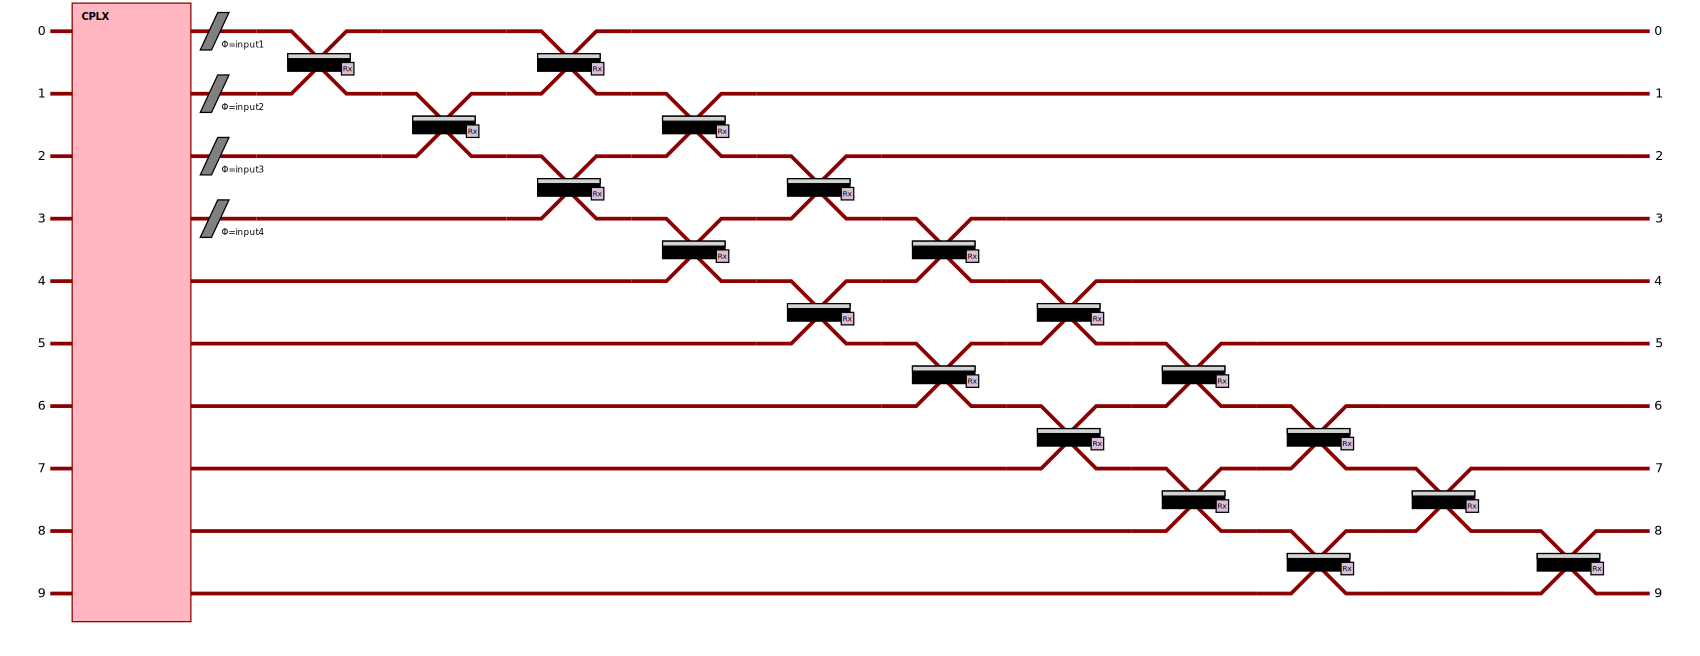

In [ ]:
# you can visualize the circuit generated by QuantumLayer.simple
pcvl.pdisplay(simple_layer.circuit)
simple_layer = QuantumLayer.simple(
    input_size=X_train.shape[1],
    n_params=10,
    output_size=3,
    output_mapping_strategy=OutputMappingStrategy.GROUPING,
    dtype=X_train.dtype,
)
losses, train_acc, test_acc = run_experiment(simple_layer, epochs=80, lr=0.01)

In [ ]:
params = [90,100,110]
test_accs, train_accs = [], []
for n_params in params:
    simple_layer = QuantumLayer.simple(
        input_size=X_train.shape[1],
        n_params=n_params,
        output_size=3,
        output_mapping_strategy=OutputMappingStrategy.GROUPING,
        dtype=X_train.dtype,
    )
    losses, train_acc, test_acc = run_experiment(simple_layer, epochs=80, lr=0.01)


## 2. Declarative builder API

`CircuitBuilder` offers a fluent interface to assemble interferometers, encoders, and trainable blocks before handing the result to `QuantumLayer`.

In [5]:
builder = CircuitBuilder(n_modes=6)
builder.add_generic_interferometer(trainable=True, name="U1")
builder.add_angle_encoding(modes=list(range(X_train.shape[1])), name="input")
builder.add_rotation_layer(trainable=True, name="theta")
builder.add_entangling_layer(depth=1)

builder_layer = QuantumLayer(
    input_size=X_train.shape[1],
    circuit=builder,
    n_photons = 3, # equivalent to input_state = [1,1,1,0,0,0]
    output_size=3,
    output_mapping_strategy=OutputMappingStrategy.GROUPING,
    dtype=X_train.dtype,
)

losses, train_acc, test_acc = run_experiment(builder_layer, epochs=80, lr=0.05)
trainable = sum(p.numel() for p in builder_layer.parameters() if p.requires_grad)
describe("CircuitBuilder pipeline", losses, train_acc, test_acc)
print(f"  trainable parameters: {trainable}")


CircuitBuilder pipeline
  epochs: 80
  final loss: 0.8170
  train accuracy: 0.893
  test accuracy: 0.842
  trainable parameters: 36


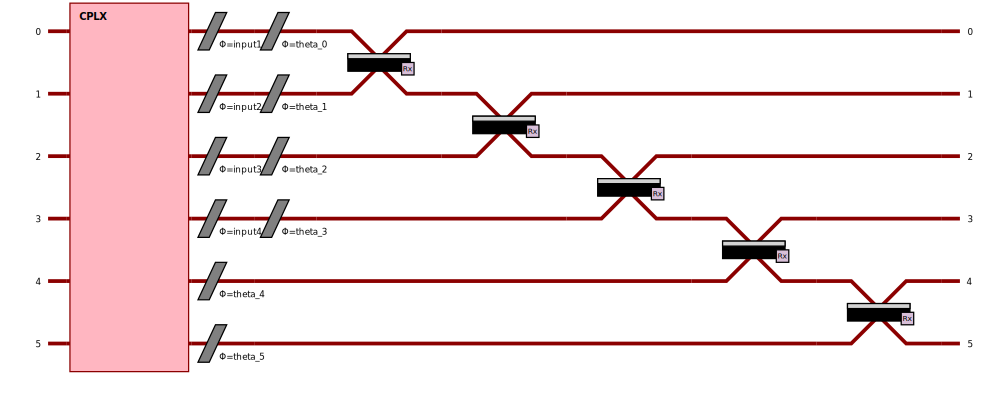

In [6]:
# you can observe your circuit
pcvl.pdisplay(builder_layer.circuit)

## 3. Hand-crafted Perceval circuit

When full control is required, build a `perceval.Circuit` manually and pass it to `QuantumLayer` alongside the parameter prefixes to train and encode.

In [10]:
modes = 6

wl = pcvl.GenericInterferometer(
    modes,
    lambda i: pcvl.BS() // pcvl.PS(pcvl.P(f"theta_li{i}")) //
    pcvl.BS() // pcvl.PS(pcvl.P(f"theta_lo{i}")),
    shape=pcvl.InterferometerShape.RECTANGLE,
)
circuit = pcvl.Circuit(modes)
circuit.add(0, wl)
for mode in range(len(iris.feature_names)):
    circuit.add(mode, pcvl.PS(pcvl.P(f"input{mode}")))
wr = pcvl.GenericInterferometer(
    modes,
    lambda i: pcvl.BS() // pcvl.PS(pcvl.P(f"theta_ri{i}")) //
    pcvl.BS() // pcvl.PS(pcvl.P(f"theta_ro{i}")),
    shape=pcvl.InterferometerShape.RECTANGLE,
)
circuit.add(0, wr)

manual_layer = QuantumLayer(
    input_size=X_train.shape[1],
    circuit=circuit,
    input_state = [1,0,1,0,1,0], # here, you can just precise the n_photons -> input_state = [1,1,1,0,0,0]
    trainable_parameters=["theta"],
    input_parameters=["input"],
    output_size=3,
    output_mapping_strategy=OutputMappingStrategy.GROUPING,
    dtype=X_train.dtype,
)

losses, train_acc, test_acc = run_experiment(manual_layer, epochs=120, lr=0.05)
trainable = sum(p.numel() for p in manual_layer.parameters() if p.requires_grad)
describe("Manual Perceval circuit", losses, train_acc, test_acc)
print(f"  trainable parameters: {trainable}")


Manual Perceval circuit
  epochs: 120
  final loss: 0.7907
  train accuracy: 0.875
  test accuracy: 0.816
  trainable parameters: 60


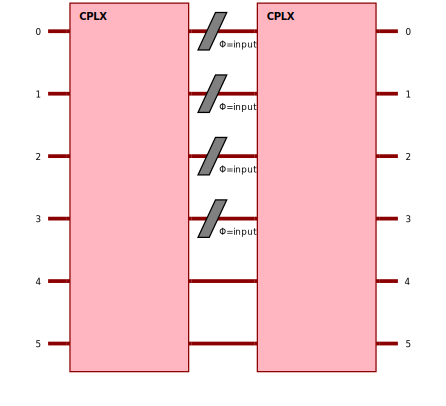

In [11]:
# you can visualize the circuit
pcvl.pdisplay(manual_layer.circuit)